In [1]:
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pygplates
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.ndimage import distance_transform_edt

In [2]:
seddata = xr.open_dataset(r'data2411\Globsed-v3.nc')
lon = np.arange(-180,180.25,0.25)
lat = np.arange(-90,90.25,0.25) #分辨率为15分
'''
lon = seddata.lon 
lat = seddata.lat #分辨率为5分 
'''
seddata = seddata.rename({'z':'sed'})
sed_interp = seddata.interp(lon = lon, lat = lat, method = 'linear')

In [3]:
agedata = xr.open_dataset(r'data2411\PresentDayAge.nc')
age_interp = agedata.interp(lon = lon, lat = lat, method = 'linear') # 用了scipy，griddata插值
age_interp = age_interp.rename({'z':'age'})

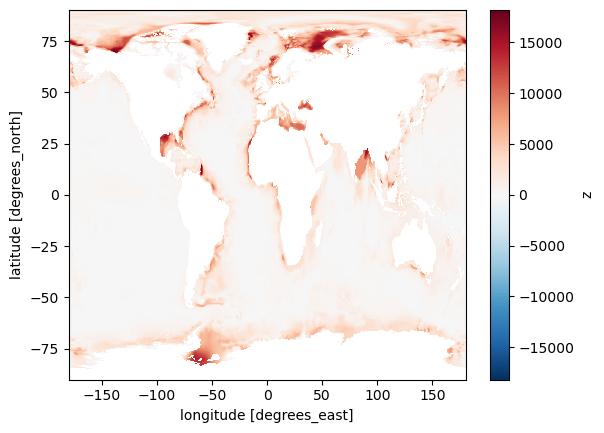

In [4]:
sed_interp.sed.plot()
# age_interp.age.plot()#add_colorbar = False)
plt.show()

In [4]:
merged = xr.merge([sed_interp, age_interp]) # 合并到一个dataset
merged.attrs.clear()
'''
merged['var_lon'] = merged['lat']  
merged.set_index(['lon', 'lat'], append=True, inplace=True)
'''
merged['var_lat'] = merged['lat'] + merged['lon']*0 # im good

In [5]:
mask = xr.open_dataset(r'landmask.nc')
# gmt grdlandmask -R-180/180/-90/90 -I0.25 -A0/0/1 -N1/0 -Di -Glandmask.nc
# 海陆蒙版landmask，海洋为1，大陆为0
numpy_mask = mask.z.values 
distances = distance_transform_edt(numpy_mask) 
merged['distance'] = xr.DataArray(data = distances, 
                                  dims = ('lat','lon'), 
                                  coords = {'lon':merged['lon'], 'lat':merged['lat']})

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
# 2. 数据集分割
sed = merged.sed.values.reshape(-1)
var_lat = merged.var_lat.values.reshape(1, -1)
age = merged.age.values.reshape(1, -1)
distance = merged.distance.values.reshape(1, -1)
X = np.vstack((var_lat, age, distance)).T # xlat_age_d
Y = sed # ysed

mask = ~np.isnan(Y)  # 创建掩码，过滤掉 NaN 值
X = X[mask]
Y = Y[mask]
mask = ~np.isnan(X).any(axis=1)  # 检查每行是否存在 NaN
X = X[mask]  # 保留没有 NaN 的行
Y = Y[mask]  # 保持 Y 和 X 行一致
print(np.isnan(Y).sum())  # 检查 Y 中的 NaN 数量
print(np.isnan(X).sum())  # X 中 NaN

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

0
0


In [8]:
# 3. 构建随机森林回归模型
print("Training Random Forest Model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)  # 初始化随机森林回归器
for _ in tqdm(range(1), desc="Model Training"):
    model.fit(X_train, y_train)  # 在训练集上训练模型

# 4. 测试模型
y_pred = model.predict(X_test)  # 在测试集上预测目标值
mse = mean_squared_error(y_test, y_pred)  # 计算均方误差
print(f"Mean Squared Error: {mse:.4f}")  # 输出模型性能

Training Random Forest Model...


Model Training: 100%|███████████████████████████████████████████████████████████████████| 1/1 [02:35<00:00, 155.96s/it]


Mean Squared Error: 133570.9645


In [9]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 365.4736


In [10]:
sed_test = model.predict(X)
sed_test

array([1582.94      , 1603.94      , 1582.94      , ..., 1873.59875488,
       1873.59875488, 1873.59875488])

[[-76.          82.77690506   5.        ]
 [-76.          82.63870239   5.        ]
 [-76.          82.77163696   5.        ]
 ...
 [ 90.          54.66313934  74.02702209]
 [ 90.          54.66313934  74.00675645]
 [ 90.          54.66313934  74.        ]]


In [ ]:
# 5. 蒙特卡洛采样 (估计某区域内 a 的期望值)
n_mc_samples = 10000  # 采样点数量
x_mc = np.random.uniform(-1, 1, n_mc_samples)  # 随机采样 x 值
y_mc = np.random.uniform(-1, 1, n_mc_samples)  # 随机采样 y 值
z_mc = np.random.uniform(-1, 1, n_mc_samples)  # 随机采样 z 值
X_mc = np.vstack((x_mc, y_mc, z_mc)).T  # 组合成输入矩阵
a_mc = model.predict(X_mc)  # 用训练好的模型预测 a 值
expected_a = np.mean(a_mc)  # 计算预测值的期望
print(f"Estimated Expected Value of a: {expected_a:.4f}")  # 输出期望值

In [ ]:
!where python